In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from datetime import datetime
import os

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [ ]:
# 读取CSV文件
df = pd.read_csv('./sample_lottery_data.csv')

# 解析前区和后区号码函数
def extract_numbers(numbers_str):
    return [int(num) for num in numbers_str.strip('"').split(',')]

# 应用解析函数到前区和后区号码列
df['front_numbers_list'] = df['front_numbers'].apply(extract_numbers)
df['back_numbers_list'] = df['back_numbers'].apply(extract_numbers)

# 取出最近10期数据
recent_df = df.head(10)

# 创建输出目录
output_dir = './lottery_results'
os.makedirs(output_dir, exist_ok=True)

In [26]:
# 1. 统计前区号码出现频率
front_numbers = []
for numbers in df['front_numbers_list']:
    front_numbers.extend(numbers)
front_counter = Counter(front_numbers)

# 统计后区号码出现频率
back_numbers = []
for numbers in df['back_numbers_list']:
    back_numbers.extend(numbers)
back_counter = Counter(back_numbers)

# 创建频率数据框
front_df = pd.DataFrame({
    'number': list(range(1, 36)),
    'frequency': [front_counter.get(i, 0) for i in range(1, 36)]
})

back_df = pd.DataFrame({
    'number': list(range(1, 13)),
    'frequency': [back_counter.get(i, 0) for i in range(1, 13)]
})

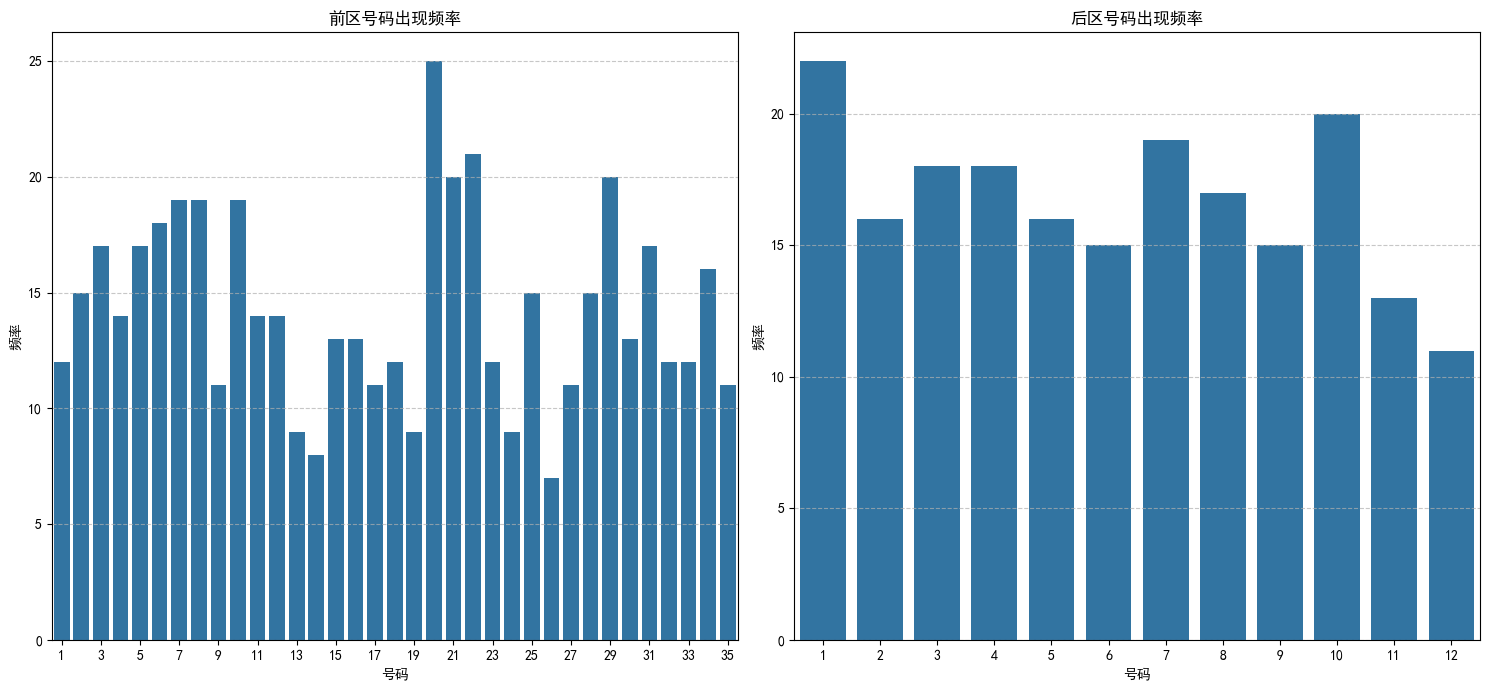

In [27]:
# 2. 可视化频率分布
plt.figure(figsize=(15, 7))

# 前区号码频率统计图
plt.subplot(1, 2, 1)
sns.barplot(x='number', y='frequency', data=front_df)
plt.title('前区号码出现频率')
plt.xlabel('号码')
plt.ylabel('频率')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 35, 2), [str(i+1) for i in range(0, 35, 2)])

# 后区号码频率统计图
plt.subplot(1, 2, 2)
sns.barplot(x='number', y='frequency', data=back_df)
plt.title('后区号码出现频率')
plt.xlabel('号码')
plt.ylabel('频率')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
# plt.savefig(f'{output_dir}/frequency_distribution.png', dpi=300)

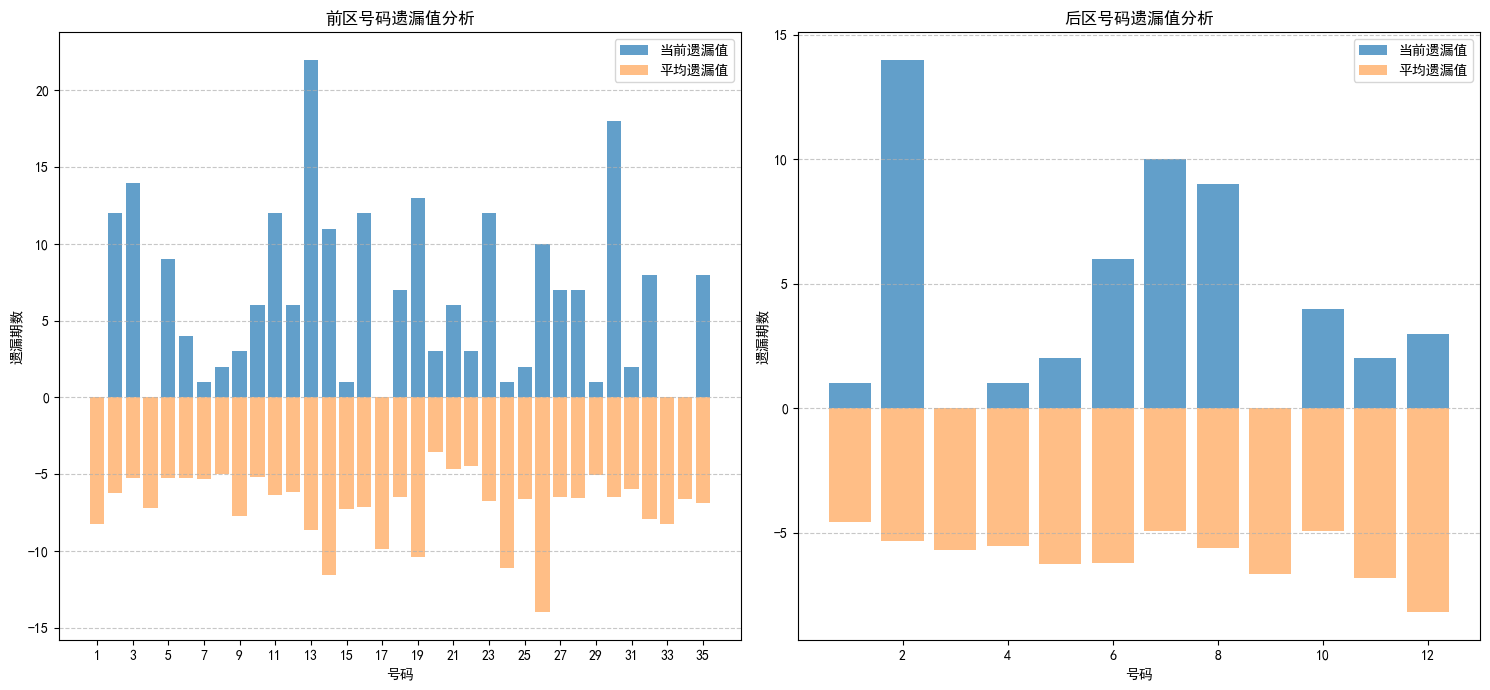

In [28]:
# 3. 分析号码遗漏值
def analyze_intervals(df, column, max_num):
    intervals = {}
    for num in range(1, max_num + 1):
        appearances = []

        for i, (_, row) in enumerate(df.iterrows()):
            if num in row[column]:
                appearances.append(i)

        # 计算当前遗漏值
        current_gap = appearances[0] if appearances else len(df)

        # 计算历史平均遗漏值
        if len(appearances) > 1:
            gaps = [appearances[i] - appearances[i+1] for i in range(len(appearances)-1)]
            avg_gap = np.mean(gaps)
        else:
            avg_gap = 0

        intervals[num] = {
            'current': current_gap,
            'average': avg_gap
        }

    return intervals

front_intervals = analyze_intervals(df, 'front_numbers_list', 35)
back_intervals = analyze_intervals(df, 'back_numbers_list', 12)

# 可视化遗漏值
plt.figure(figsize=(15, 7))

# 前区遗漏值
plt.subplot(1, 2, 1)
current_gaps = [front_intervals[i]['current'] for i in range(1, 36)]
avg_gaps = [front_intervals[i]['average'] for i in range(1, 36)]

plt.bar(range(1, 36), current_gaps, alpha=0.7, label='当前遗漏值')
plt.bar(range(1, 36), avg_gaps, alpha=0.5, label='平均遗漏值')
plt.title('前区号码遗漏值分析')
plt.xlabel('号码')
plt.ylabel('遗漏期数')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(1, 36, 2))

# 后区遗漏值
plt.subplot(1, 2, 2)
current_gaps = [back_intervals[i]['current'] for i in range(1, 13)]
avg_gaps = [back_intervals[i]['average'] for i in range(1, 13)]

plt.bar(range(1, 13), current_gaps, alpha=0.7, label='当前遗漏值')
plt.bar(range(1, 13), avg_gaps, alpha=0.5, label='平均遗漏值')
plt.title('后区号码遗漏值分析')
plt.xlabel('号码')
plt.ylabel('遗漏期数')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
# plt.savefig(f'{output_dir}/missing_values.png', dpi=300)

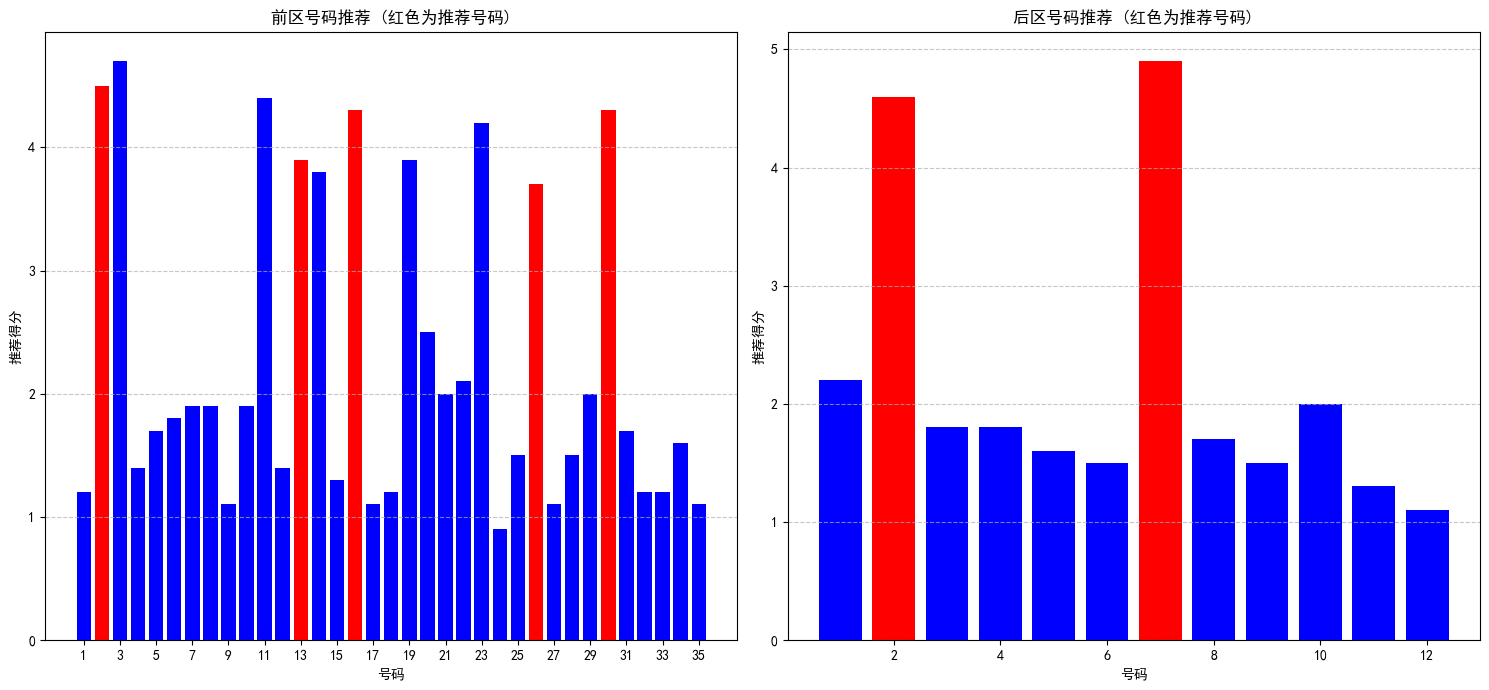

In [29]:
# 4. 推荐号码算法
def recommend_numbers():
    # 计算号码得分
    front_scores = {}
    for num in range(1, 36):
        # 频率得分 - 出现频率越高分数越高
        freq_score = front_counter.get(num, 0) / len(df) * 10

        # 遗漏值得分 - 遗漏值接近平均值得高分
        miss_score = 0
        if front_intervals[num]['average'] > 0:
            ratio = front_intervals[num]['current'] / front_intervals[num]['average']
            # 当前遗漏接近平均遗漏的1.5-2倍时给高分
            if 1.5 <= ratio <= 2.5:
                miss_score = 5

        # 冷热平衡分数
        balance_score = 0
        recent_count = sum(1 for i, row in recent_df.iterrows() if num in row['front_numbers_list'])
        if recent_count == 0:  # 最近没出现过
            balance_score = 3

        # 总分
        front_scores[num] = freq_score + miss_score + balance_score

    # 后区号码得分
    back_scores = {}
    for num in range(1, 13):
        # 频率得分
        freq_score = back_counter.get(num, 0) / len(df) * 10

        # 遗漏值得分
        miss_score = 0
        if back_intervals[num]['average'] > 0:
            ratio = back_intervals[num]['current'] / back_intervals[num]['average']
            if 1.5 <= ratio <= 2.5:
                miss_score = 5

        # 冷热平衡分数
        balance_score = 0
        recent_count = sum(1 for i, row in recent_df.iterrows() if num in row['back_numbers_list'])
        if recent_count == 0:
            balance_score = 3

        # 总分
        back_scores[num] = freq_score + miss_score + balance_score

    # 排序并选择高分号码
    front_candidates = sorted(front_scores.items(), key=lambda x: x[1], reverse=True)[:12]
    back_candidates = sorted(back_scores.items(), key=lambda x: x[1], reverse=True)[:5]

    # 从候选中随机选择5个前区号码和2个后区号码
    recommended_front = sorted(random.sample([num for num, _ in front_candidates], 5))
    recommended_back = sorted(random.sample([num for num, _ in back_candidates], 2))

    return recommended_front, recommended_back, front_scores, back_scores

# 生成推荐号码
front_recommendation, back_recommendation, front_scores, back_scores = recommend_numbers()

# 可视化推荐号码
plt.figure(figsize=(15, 7))

# 前区号码推荐可视化
plt.subplot(1, 2, 1)
all_scores = [front_scores[i] for i in range(1, 36)]
colors = ['red' if i in front_recommendation else 'blue' for i in range(1, 36)]
plt.bar(range(1, 36), all_scores, color=colors)
plt.title('前区号码推荐 (红色为推荐号码)')
plt.xlabel('号码')
plt.ylabel('推荐得分')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(1, 36, 2))

# 后区号码推荐可视化
plt.subplot(1, 2, 2)
all_scores = [back_scores[i] for i in range(1, 13)]
colors = ['red' if i in back_recommendation else 'blue' for i in range(1, 13)]
plt.bar(range(1, 13), all_scores, color=colors)
plt.title('后区号码推荐 (红色为推荐号码)')
plt.xlabel('号码')
plt.ylabel('推荐得分')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
# plt.savefig(f'{output_dir}/recommended_numbers.png', dpi=300)

In [30]:
# 5. 生成推荐报告
print("\n===== 大乐透号码分析报告 =====")
print(f"数据分析范围: 从 {df['issue_num'].iloc[-1]} 期到 {df['issue_num'].iloc[0]} 期")
print(f"共计分析 {len(df)} 期数据")

print("\n前区号码出现频率TOP5:")
for num, freq in front_df.sort_values('frequency', ascending=False).head(5).values:
    print(f"号码 {num}: 出现 {freq} 次")

print("\n后区号码出现频率TOP3:")
for num, freq in back_df.sort_values('frequency', ascending=False).head(3).values:
    print(f"号码 {num}: 出现 {freq} 次")

print("\n==== 2025年7月2日大乐透推荐号码 ====")
print(f"前区: {', '.join(map(str, front_recommendation))}")
print(f"后区: {', '.join(map(str, back_recommendation))}")
print("祝您好运!")

# 将推荐结果保存到文件
with open(f'{output_dir}/lottery_recommendation.txt', 'w', encoding='utf-8') as f:
    f.write("===== 大乐透号码分析报告 =====\n")
    f.write(f"数据分析范围: 从 {df['issue_num'].iloc[-1]} 期到 {df['issue_num'].iloc[0]} 期\n")
    f.write(f"共计分析 {len(df)} 期数据\n\n")
    f.write("前区号码出现频率TOP5:\n")
    for num, freq in front_df.sort_values('frequency', ascending=False).head(5).values:
        f.write(f"号码 {num}: 出现 {freq} 次\n")
    f.write("\n后区号码出现频率TOP3:\n")
    for num, freq in back_df.sort_values('frequency', ascending=False).head(3).values:
        f.write(f"号码 {num}: 出现 {freq} 次\n")
    f.write("\n==== 2025年7月2日大乐透推荐号码 ====\n")
    f.write(f"前区: {', '.join(map(str, front_recommendation))}\n")
    f.write(f"后区: {', '.join(map(str, back_recommendation))}\n")
    f.write("祝您好运!\n")

print(f"\n分析结果已保存至 {output_dir} 目录")


===== 大乐透号码分析报告 =====
数据分析范围: 从 24126 期到 25073 期
共计分析 100 期数据

前区号码出现频率TOP5:
号码 20: 出现 25 次
号码 22: 出现 21 次
号码 21: 出现 20 次
号码 29: 出现 20 次
号码 7: 出现 19 次

后区号码出现频率TOP3:
号码 1: 出现 22 次
号码 10: 出现 20 次
号码 7: 出现 19 次

==== 2025年7月2日大乐透推荐号码 ====
前区: 2, 13, 16, 26, 30
后区: 2, 7
祝您好运!

分析结果已保存至 ./lottery_results 目录
